In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
df = pd.read_csv('us-states.csv')

In [3]:
# Sort to choose which states to consider
# df.groupby(['state']).sum().sort_values(by=['deaths'])

States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

In [4]:
California = df[df['state']=='California']
NewYork = df[df['state']=='New York']
Texas = df[df['state']=='Texas']

Virginia = df[df['state']=='Virginia']

NorthernMarianaIslands = df[df['state']=='Northern Mariana Islands']
VirginIslands= df[df['state']=='Virgin Islands']
Guam= df[df['state']=='Guam']

# Preprocessing Data

In [36]:
state = 'VirginIslands'
cases_deaths  = VirginIslands[['cases','deaths']].to_numpy()
# cases_deaths[:,0]= cumulative_to_daily(cases_deaths[:,0])
# cases_deaths[:,1]= cumulative_to_daily(cases_deaths[:,1])

scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
cases_deaths = scaler.fit_transform(cases_deaths)

In [37]:
scaler.data_max_

array([3068.,   27.])

In [38]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [39]:
cases_deaths=cases_deaths[13:] # Skip the first days where there's no data

In [40]:
window_size = 40

X,Y = convert_to_slide_window(cases_deaths,window_size)
split = int(len(X) * 0.8)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Daily + Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Daily + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [41]:
TST_model = TimeSeriesTransformer(n_features=2,d_model=128, n_heads=4, n_hidden=128, n_layers=4 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}'.format(state)))

Epoch 1 Loss is 0.9476763672298856
Epoch 2 Loss is 0.8197059101528592
Epoch 3 Loss is 0.7132007214758131
Epoch 4 Loss is 0.5990561644236246
Epoch 5 Loss is 0.45805438028441536
Epoch 6 Loss is 0.3183194398880005
Epoch 7 Loss is 0.22931801113817427
Epoch 8 Loss is 0.20087343785497877
Epoch 9 Loss is 0.1834119591448042
Epoch 10 Loss is 0.16184043222003514
Epoch 11 Loss is 0.14386189646191067
Epoch 12 Loss is 0.1250689576069514
Epoch 13 Loss is 0.10505450185802248
Epoch 14 Loss is 0.08620551476875941
Epoch 15 Loss is 0.0681196724375089
Epoch 16 Loss is 0.0529133097993003
Epoch 17 Loss is 0.039602783819039665
Epoch 18 Loss is 0.028633775603440072
Epoch 19 Loss is 0.021338999478353396
Epoch 20 Loss is 0.016990748027132616
Epoch 21 Loss is 0.01500572171062231
Epoch 22 Loss is 0.014325501190291511
Epoch 23 Loss is 0.013505788313017951
Epoch 24 Loss is 0.013151854380137391
Epoch 25 Loss is 0.012605731272035174
Epoch 26 Loss is 0.012501127293540372
Epoch 27 Loss is 0.012057282444503572
Epoch 28 

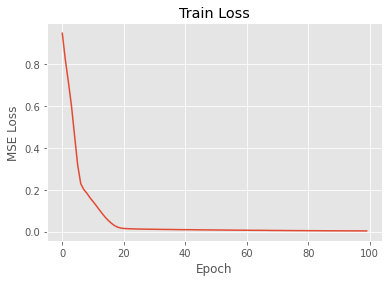

In [42]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [43]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print(predicted.shape)
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test).cpu().detach().numpy()

torch.Size([40, 71, 2])
TST: Test MSE Loss:  0.017635608091950417


In [44]:
X_train[-1].shape

torch.Size([40, 2])

In [45]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0634, device='cuda:0', grad_fn=<MseLossBackward>)


In [46]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 398978 Parameters for the transformer model


In [47]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST)

In [48]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_TST[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_TST[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_TST[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_TST[:,1]))

R2 Score for Cases 0.9777341605754505
MAPE Score for Cases 0.08655945
R2 Score for Deaths 0.9975923932032885
MAPE Score for Deaths 0.030419433


# LSTM Model

In [49]:
LSTM_model = COVID_LSTM(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}'.format(state)))

Epoch 1 Loss is 0.32247741023699444
Epoch 2 Loss is 0.30947066677941215
Epoch 3 Loss is 0.2991093397140503
Epoch 4 Loss is 0.2847020344601737
Epoch 5 Loss is 0.2680167704820633
Epoch 6 Loss is 0.24712487061818442
Epoch 7 Loss is 0.20663286911116707
Epoch 8 Loss is 0.13663489288753933
Epoch 9 Loss is 0.06940930957595508
Epoch 10 Loss is 0.02903157327738073
Epoch 11 Loss is 0.019489859230816364
Epoch 12 Loss is 0.01950148731056187
Epoch 13 Loss is 0.017119228632913694
Epoch 14 Loss is 0.016095025050971244
Epoch 15 Loss is 0.01570677457170354
Epoch 16 Loss is 0.014541379486521086
Epoch 17 Loss is 0.014251140981084771
Epoch 18 Loss is 0.013593977834615443
Epoch 19 Loss is 0.012898064425422085
Epoch 20 Loss is 0.012229396030306816
Epoch 21 Loss is 0.0115423993104034
Epoch 22 Loss is 0.010835673660039902
Epoch 23 Loss is 0.010190642335348658
Epoch 24 Loss is 0.009512967895716429
Epoch 25 Loss is 0.008941012227700816
Epoch 26 Loss is 0.0082102802892526
Epoch 27 Loss is 0.007677892067780097
Ep

In [50]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test).cpu().detach().numpy()

LSTM: Test MSE Loss:  0.013950630091130733


In [51]:
X_test.shape

torch.Size([71, 40, 2])

In [52]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward>)


In [53]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM)

In [54]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_LSTM[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_LSTM[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_LSTM[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_LSTM[:,1]))

R2 Score for Cases 0.986302772604764
MAPE Score for Cases 0.070348516
R2 Score for Deaths 0.9962590487391321
MAPE Score for Deaths 0.036369886


# GRU Model

In [55]:
GRU_model = COVID_GRU(n_hidden=128,n_features=2).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}'.format(state)))

Epoch 1 Loss is 0.3128746251265208
Epoch 2 Loss is 0.27314767903751797
Epoch 3 Loss is 0.23785696427027384
Epoch 4 Loss is 0.2047900441620085
Epoch 5 Loss is 0.16081934173901877
Epoch 6 Loss is 0.10198209020826551
Epoch 7 Loss is 0.03942387778725889
Epoch 8 Loss is 0.01267697455154525
Epoch 9 Loss is 0.012810546283920607
Epoch 10 Loss is 0.008308146562841203
Epoch 11 Loss is 0.007737280438757605
Epoch 12 Loss is 0.0074003625971575575
Epoch 13 Loss is 0.007137636602338817
Epoch 14 Loss is 0.006868904611716668
Epoch 15 Loss is 0.0067259652229646845
Epoch 16 Loss is 0.006541919428855181
Epoch 17 Loss is 0.006436202519883712
Epoch 18 Loss is 0.006279084883216355
Epoch 19 Loss is 0.006256486599644025
Epoch 20 Loss is 0.00611309751143886
Epoch 21 Loss is 0.005977927189734247
Epoch 22 Loss is 0.005965875099516577
Epoch 23 Loss is 0.005745445533345143
Epoch 24 Loss is 0.005568846491061979
Epoch 25 Loss is 0.0054562515837864745
Epoch 26 Loss is 0.0053637939919200205
Epoch 27 Loss is 0.005299891

In [56]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test).cpu().detach().numpy()

GRU: Test MSE Loss:  0.01578928343951702


In [57]:
X_test.shape

torch.Size([71, 40, 2])

In [58]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size ).cpu().detach().numpy()

Test MSE Loss:  tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward>)


In [59]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU)

In [60]:
print('R2 Score for Cases',r2_score(daily_to_cumulative(y_test_inverse[:,0]),daily_to_cumulative(forecasted_inverse_GRU[:,0])))
print('MAPE Score for Cases',mean_absolute_percentage_error(y_test_inverse[:,0],forecasted_inverse_GRU[:,0]))

print('R2 Score for Deaths',r2_score(daily_to_cumulative(y_test_inverse[:,1]),daily_to_cumulative(forecasted_inverse_GRU[:,1])))
print('MAPE Score for Deaths',mean_absolute_percentage_error(y_test_inverse[:,1],forecasted_inverse_GRU[:,1]))

R2 Score for Cases 0.9809500158814376
MAPE Score for Cases 0.08014232
R2 Score for Deaths 0.9965573625702198
MAPE Score for Deaths 0.034525327


# Plots

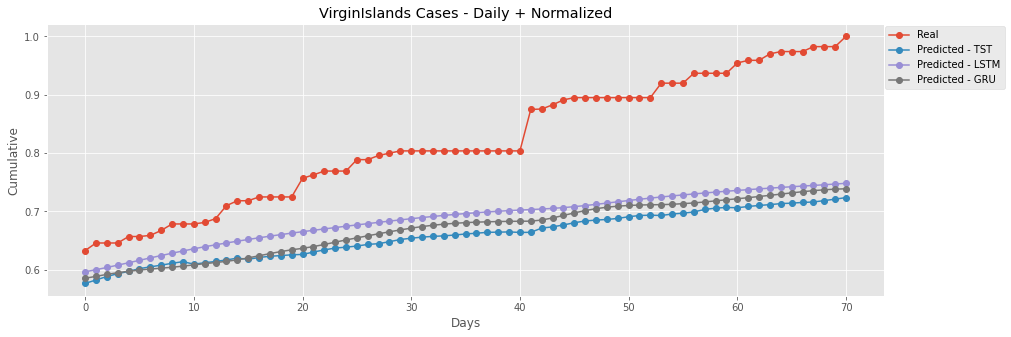

In [61]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

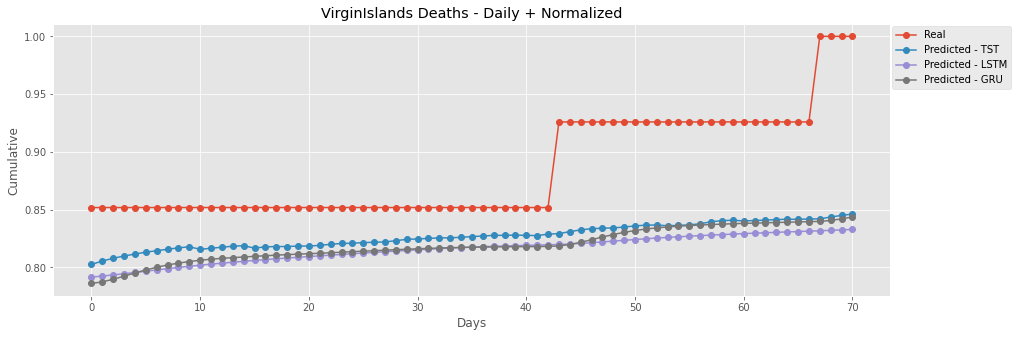

In [62]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,1].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,1],label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,1].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

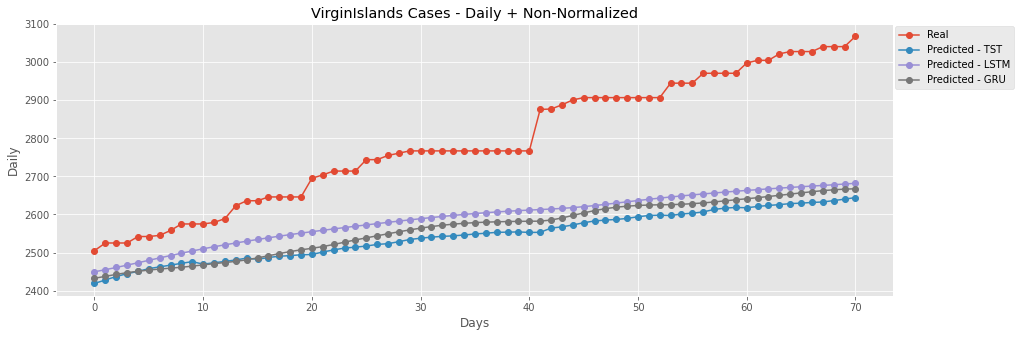

In [63]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Cases - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

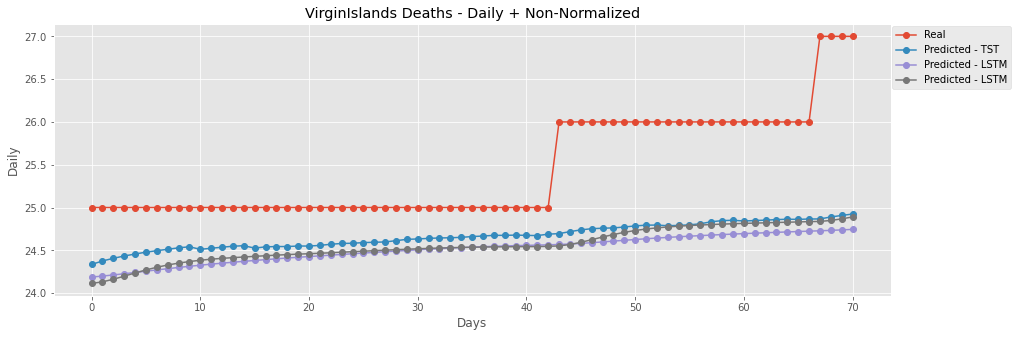

In [64]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,1],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,1],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,1],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,1],label='Predicted - LSTM',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Deaths - Daily + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Daily')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()